# Capacity on buses - Logistic Regression

In [1]:
# import packages
import pandas as pd
desired_width = 320
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt

# expand ouput display for columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


# Use case:
- Predict bus capacity for one bus stop(s) ahead
- Provide probability for "full bus": High, medium, low



### Load dataset from xlsx File for Line 37 - 2+ months

In [2]:
# read csv
df = pd.read_csv("L37_2020_03_05.txt", encoding = "ISO-8859-1",sep='\t')

df.head()

,Trip_id,OP_DAY,vehicle_no,line_no,line_name,ROUTE_DIRECTION,QUAYREF,STOPPLACEREF,STOPPLACENAME,STOP_IDX,PLAN_START_TIME,REAL_START_TIME,SCHED_ARR_TIME,SCHED_DEP_TIME,ACT_ARR_TIME,ACT_DEP_TIME,BOARDING_ORG,ALIGHTING_ORG,SOURCESYSTEM,Exclude_flg,FK_DTime_Plan_End_Time,MATCHINGLOGIC,ROUTESERVICEMODE,ROUTESERVICETYPE,ROUTECOUNTYNAME
0,563241428,2020-03-07 00:00:00,103048,37,37,1,NSR:Quay:12076,NSR:StopPlace:6540,Galgeberg,4,16500,16602,16740,16740,16878,16878,5.0,0.0,APT1_SIS,0,18360,Direct,Buss,Lokal,Oslo
1,563241428,2020-03-07 00:00:00,103048,37,37,1,NSR:Quay:11566,NSR:StopPlace:6297,Lovisenberg,16,16500,16602,17700,17700,17785,17785,0.0,0.0,APT1_SIS,0,18360,Direct,Buss,Lokal,Oslo
2,563241518,2020-03-07 00:00:00,103048,37,37,0,NSR:Quay:11795,NSR:StopPlace:6418,Kristoffer Aamots gate,1,19020,19093,19080,19080,19127,19127,0.0,0.0,APT1_SIS,0,21240,Direct,Buss,Lokal,Oslo
3,563241518,2020-03-07 00:00:00,103048,37,37,0,NSR:Quay:11534,NSR:StopPlace:6281,Stensberggata,13,19020,19093,19920,19920,19906,19930,2.0,0.0,APT1_SIS,0,21240,Direct,Buss,Lokal,Oslo
4,563241518,2020-03-07 00:00:00,103048,37,37,0,NSR:Quay:12083,NSR:StopPlace:6544,Etterstadgata,25,19020,19093,20940,20940,20943,20943,0.0,0.0,APT1_SIS,0,21240,Direct,Buss,Lokal,Oslo


In [3]:
# output column labels of the DataFrame
df.columns

Index(['Trip_id', 'OP_DAY', 'vehicle_no', 'line_no', 'line_name',
       'ROUTE_DIRECTION', 'QUAYREF', 'STOPPLACEREF', 'STOPPLACENAME',
       'STOP_IDX', 'PLAN_START_TIME', 'REAL_START_TIME', 'SCHED_ARR_TIME',
       'SCHED_DEP_TIME', 'ACT_ARR_TIME', 'ACT_DEP_TIME', 'BOARDING_ORG',
       'ALIGHTING_ORG', 'SOURCESYSTEM', 'Exclude_flg',
       'FK_DTime_Plan_End_Time', 'MATCHINGLOGIC', 'ROUTESERVICEMODE',
       'ROUTESERVICETYPE', 'ROUTECOUNTYNAME'],
      dtype='object')

In [4]:
# output dtypes in dataframe
df.dtypes

Trip_id                     int64
OP_DAY                     object
vehicle_no                  int64
line_no                     int64
line_name                   int64
ROUTE_DIRECTION             int64
QUAYREF                    object
STOPPLACEREF               object
STOPPLACENAME              object
STOP_IDX                    int64
PLAN_START_TIME             int64
REAL_START_TIME             int64
SCHED_ARR_TIME              int64
SCHED_DEP_TIME              int64
ACT_ARR_TIME                int64
ACT_DEP_TIME                int64
BOARDING_ORG              float64
ALIGHTING_ORG             float64
SOURCESYSTEM               object
Exclude_flg                 int64
FK_DTime_Plan_End_Time      int64
MATCHINGLOGIC              object
ROUTESERVICEMODE           object
ROUTESERVICETYPE           object
ROUTECOUNTYNAME            object
dtype: object

### Evaluating for Missing data

In [5]:
# return boolean for detecting missing values
missing_data = df.isnull()

In [6]:
# for loop to count the numbers of missing values in each column.
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")    

Trip_id
False    591278
Name: Trip_id, dtype: int64

OP_DAY
False    591278
Name: OP_DAY, dtype: int64

vehicle_no
False    591278
Name: vehicle_no, dtype: int64

line_no
False    591278
Name: line_no, dtype: int64

line_name
False    591278
Name: line_name, dtype: int64

ROUTE_DIRECTION
False    591278
Name: ROUTE_DIRECTION, dtype: int64

QUAYREF
False    591278
Name: QUAYREF, dtype: int64

STOPPLACEREF
False    591278
Name: STOPPLACEREF, dtype: int64

STOPPLACENAME
False    591278
Name: STOPPLACENAME, dtype: int64

STOP_IDX
False    591278
Name: STOP_IDX, dtype: int64

PLAN_START_TIME
False    591278
Name: PLAN_START_TIME, dtype: int64

REAL_START_TIME
False    591278
Name: REAL_START_TIME, dtype: int64

SCHED_ARR_TIME
False    591278
Name: SCHED_ARR_TIME, dtype: int64

SCHED_DEP_TIME
False    591278
Name: SCHED_DEP_TIME, dtype: int64

ACT_ARR_TIME
False    591278
Name: ACT_ARR_TIME, dtype: int64

ACT_DEP_TIME
False    591278
Name: ACT_DEP_TIME, dtype: int64

BOARDING_ORG
False    57

Based on the summary above, there are:
- 13401 missing values for 'aligthing_org' and 'boarding_org'

In [7]:
# drop whole rows with NULL in "alighting","boarding_org" column
df.dropna(subset=['ALIGHTING_ORG','BOARDING_ORG'], axis=0, inplace=True)

# reset index, because we droped 4300 rows
df.reset_index(drop=True, inplace=True)

## Selection

In [8]:
# create new dataframe with selected columns
# sorted in the following order 'OP_DAY','TRIP_ID','ACT_ARR_TIME'.
capacity_df = df[['Trip_id', 'OP_DAY', 'vehicle_no', 'line_no',
       'ROUTE_DIRECTION', 'QUAYREF', 'STOPPLACEREF', 'STOPPLACENAME',
       'STOP_IDX', 'ACT_ARR_TIME', 'ACT_DEP_TIME', 'BOARDING_ORG',
       'ALIGHTING_ORG']].sort_values(by=['OP_DAY','vehicle_no','Trip_id','ACT_ARR_TIME'], ascending = True)


In [9]:
# reset index
capacity_df.reset_index(inplace = True)

In [10]:
#capacity_df['vehicle_no'].unique()

In [11]:
%%time
#LOAD
# load += boarding - alighting
#cumsum()?
capacity_df['LOAD_NET'] = capacity_df['BOARDING_ORG']-capacity_df['ALIGHTING_ORG']
capacity_df['LOAD'] = capacity_df.groupby(['Trip_id'])['LOAD_NET'].apply(lambda x: x.cumsum())

"""trip_id = 0
prev_load = 0
for index, row in capacity_df.iterrows():
    if row["Trip_id"] != trip_id:
        trip_id = row["Trip_id"]
        capacity_df.loc[index, "LOAD"] = row["BOARDING_ORG"] - row["ALIGHTING_ORG"]
    else:
        capacity_df.loc[index, "LOAD"] = prev_load + row["BOARDING_ORG"] - row["ALIGHTING_ORG"]
    prev_load = capacity_df.loc[index, "LOAD"]

"""


CPU times: user 3.31 s, sys: 76.4 ms, total: 3.39 s
Wall time: 3.38 s


'trip_id = 0\nprev_load = 0\nfor index, row in capacity_df.iterrows():\n    if row["Trip_id"] != trip_id:\n        trip_id = row["Trip_id"]\n        capacity_df.loc[index, "LOAD"] = row["BOARDING_ORG"] - row["ALIGHTING_ORG"]\n    else:\n        capacity_df.loc[index, "LOAD"] = prev_load + row["BOARDING_ORG"] - row["ALIGHTING_ORG"]\n    prev_load = capacity_df.loc[index, "LOAD"]\n\n'

In [12]:
capacity_df.head()

,index,Trip_id,OP_DAY,vehicle_no,line_no,ROUTE_DIRECTION,QUAYREF,STOPPLACEREF,STOPPLACENAME,STOP_IDX,ACT_ARR_TIME,ACT_DEP_TIME,BOARDING_ORG,ALIGHTING_ORG,LOAD_NET,LOAD
0,136488,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11162,NSR:StopPlace:6078,Nydalen T,0,4375,4642,3.0,1.0,2.0,2.0
1,136489,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11795,NSR:StopPlace:6418,Kristoffer Aamots gate,1,4697,4697,15.0,0.0,15.0,17.0
2,136490,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11725,NSR:StopPlace:6380,Kristoffer Aamots bro,2,4794,4794,0.0,0.0,0.0,17.0
3,136491,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11718,NSR:StopPlace:6376,Badebakken,3,4855,4864,1.0,0.0,1.0,18.0
4,136492,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11703,NSR:StopPlace:6369,Bjølsen,4,4937,4958,3.0,3.0,0.0,18.0


In [13]:
# SAMPLE
#sample_capacity_df = capacity_df[0:100000]

In [14]:
%%time
# converts 'LOAD'data of passengers to a binomial factor labeled 'CAPACITY'
#- 0 if bus capacity is equal or less than 50 %.
#- 1 if bus is greater than 50 %.

capacity_df['CAPACITY'] = capacity_df['LOAD'].apply(lambda x: 1 if x >=50 else 0)




CPU times: user 218 ms, sys: 17.5 ms, total: 236 ms
Wall time: 235 ms


In [15]:
%%time
# move cell for capacity 1 row below i.e. predict capacity for 1 bus stop ahead
# 

capacity_df['capacity_1_forward'] = capacity_df.groupby('Trip_id')['CAPACITY'].shift(-1)



CPU times: user 67.3 ms, sys: 42.9 ms, total: 110 ms
Wall time: 109 ms


In [16]:
#assuming that capacity at last bus stop equals to zero:
capacity_df["capacity_1_forward"].fillna(0, inplace = True) 

In [17]:
capacity_df.head()

,index,Trip_id,OP_DAY,vehicle_no,line_no,ROUTE_DIRECTION,QUAYREF,STOPPLACEREF,STOPPLACENAME,STOP_IDX,ACT_ARR_TIME,ACT_DEP_TIME,BOARDING_ORG,ALIGHTING_ORG,LOAD_NET,LOAD,CAPACITY,capacity_1_forward
0,136488,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11162,NSR:StopPlace:6078,Nydalen T,0,4375,4642,3.0,1.0,2.0,2.0,0,0.0
1,136489,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11795,NSR:StopPlace:6418,Kristoffer Aamots gate,1,4697,4697,15.0,0.0,15.0,17.0,0,0.0
2,136490,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11725,NSR:StopPlace:6380,Kristoffer Aamots bro,2,4794,4794,0.0,0.0,0.0,17.0,0,0.0
3,136491,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11718,NSR:StopPlace:6376,Badebakken,3,4855,4864,1.0,0.0,1.0,18.0,0,0.0
4,136492,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11703,NSR:StopPlace:6369,Bjølsen,4,4937,4958,3.0,3.0,0.0,18.0,0,0.0


In [18]:
capacity_df['CAPACITY'].value_counts()

0    572580
1      5297
Name: CAPACITY, dtype: int64

In [19]:
"""converts date to weekday"""

def convert_date_to_weekday(date):
    a = capacity_df[date].astype(str).str[0:10]
    a = pd.to_datetime(a)
    a = a.dt.day_name()
    return a

date_converted = convert_date_to_weekday('OP_DAY')
date_df = pd.DataFrame(date_converted)

date_df = date_df.rename(columns={"OP_DAY":"WEEKDAY"})
date_df.head()

,WEEKDAY
0,Sunday
1,Sunday
2,Sunday
3,Sunday
4,Sunday


In [20]:
weekday_dummy_df = pd.get_dummies(date_df['WEEKDAY']).astype(np.int64)
weekday_dummy_df.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


In [21]:
# merge dataframe 'capacity_df' with dataframe for weekdays.
capacity_df = pd.concat([capacity_df, pd.get_dummies(date_df['WEEKDAY']).astype(np.int64)], axis=1)
capacity_df.head()

,index,Trip_id,OP_DAY,vehicle_no,line_no,ROUTE_DIRECTION,QUAYREF,STOPPLACEREF,STOPPLACENAME,STOP_IDX,ACT_ARR_TIME,ACT_DEP_TIME,BOARDING_ORG,ALIGHTING_ORG,LOAD_NET,LOAD,CAPACITY,capacity_1_forward,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,136488,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11162,NSR:StopPlace:6078,Nydalen T,0,4375,4642,3.0,1.0,2.0,2.0,0,0.0,0,0,0,1,0,0,0
1,136489,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11795,NSR:StopPlace:6418,Kristoffer Aamots gate,1,4697,4697,15.0,0.0,15.0,17.0,0,0.0,0,0,0,1,0,0,0
2,136490,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11725,NSR:StopPlace:6380,Kristoffer Aamots bro,2,4794,4794,0.0,0.0,0.0,17.0,0,0.0,0,0,0,1,0,0,0
3,136491,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11718,NSR:StopPlace:6376,Badebakken,3,4855,4864,1.0,0.0,1.0,18.0,0,0.0,0,0,0,1,0,0,0
4,136492,555908637,2020-03-01 00:00:00,101034,37,0,NSR:Quay:11703,NSR:StopPlace:6369,Bjølsen,4,4937,4958,3.0,3.0,0.0,18.0,0,0.0,0,0,0,1,0,0,0


### Visualization

In [22]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(15,7))
# use unstack()


### Defining X, and y for dataset

In [23]:
# define X as independent variabel for dataset
X = np.asarray(capacity_df[['ALIGHTING_ORG', 'BOARDING_ORG', 'LOAD','Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday','Sunday']])
#X = np.asarray(capacity_df[['LOAD']])
X[0:5]

array([[ 1.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0., 15., 17.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0., 17.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1., 18.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 3.,  3., 18.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [24]:
# define y as dependent variabel for dataset
y = np.asarray(capacity_df['capacity_1_forward'])
y [0:5]

array([0., 0., 0., 0., 0.])

In [25]:
# Normalize the dataset
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.17588595,  0.57225132, -0.70357876, -0.42340977, -0.43151344,
        -0.4297657 , -0.42819921, -0.42063251, -0.37287731,  2.87753073],
       [-0.54498426,  5.00495139,  0.7985655 , -0.42340977, -0.43151344,
        -0.4297657 , -0.42819921, -0.42063251, -0.37287731,  2.87753073],
       [-0.54498426, -0.5359237 ,  0.7985655 , -0.42340977, -0.43151344,
        -0.4297657 , -0.42819921, -0.42063251, -0.37287731,  2.87753073],
       [-0.54498426, -0.16653202,  0.89870845, -0.42340977, -0.43151344,
        -0.4297657 , -0.42819921, -0.42063251, -0.37287731,  2.87753073],
       [ 0.56231066,  0.57225132,  0.89870845, -0.42340977, -0.43151344,
        -0.4297657 , -0.42819921, -0.42063251, -0.37287731,  2.87753073]])

## Modeling (Logistic Regression with Scikit-learn)

In [26]:
#split dataset into train and test set. train size = 80 %, test_size = 20 %
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (462301, 10) (462301,)
Test set: (115576, 10) (115576,)


In [27]:
#C parameter indicates inverse of regularization strength
#C = 0.01

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=1, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
# predict using the test set
yhat = LR.predict(X_test)
yhat

array([0., 0., 0., ..., 0., 0., 0.])

In [29]:
#__predict_proba__ returns estimates for all classes, ordered by the label of classes. 
#So, the first column is the probability of class 1, P(Y=1|X),
#and second column is probability of class 0, P(Y=0|X):"""

yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[9.99991171e-01, 8.82930120e-06],
       [9.99971758e-01, 2.82420474e-05],
       [9.99989940e-01, 1.00604004e-05],
       ...,
       [9.99996751e-01, 3.24947365e-06],
       [9.99997608e-01, 2.39242544e-06],
       [9.98702512e-01, 1.29748841e-03]])

In [30]:
yhat_prob.shape

(115576, 2)

In [31]:
# jaccard similarity score
#from sklearn.metrics import jaccard_similarity_score
#jaccard_similarity_score(y_test, yhat) 


In [32]:
# jaccard score
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat)


0.6397058823529411

In [33]:
# accurary score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yhat)

0.9961843289264207

### Confusion matrix

In [34]:
# confusion matrix: accuracy of classifier
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[   783    288]
 [   153 114352]]


Confusion matrix, without normalization
[[   783    288]
 [   153 114352]]


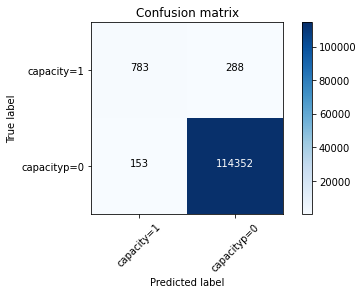

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['capacity=1','capacityp=0'],normalize= False,  title='Confusion matrix')

In [36]:
# classification report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    114505
         1.0       0.84      0.73      0.78      1071

    accuracy                           1.00    115576
   macro avg       0.92      0.86      0.89    115576
weighted avg       1.00      1.00      1.00    115576



In [37]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(LR.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(LR.score(X_test, y_test)))

Training set score: 0.9962
Test set score: 0.9962


### Categorizing 'High, medium, low' for bus capacity

In [38]:
pd.set_option("display.precision", 8)
diff_df = pd.DataFrame({'Actual': y_test, 'Predicted': yhat, 'Prob_cap_1': yhat_prob[:,1]})
diff_df.head()

,Actual,Predicted,Prob_cap_1
0,0.0,0.0,0.00000883
1,0.0,0.0,0.00002824
2,0.0,0.0,0.00001006
3,0.0,0.0,0.00000498
4,0.0,0.0,0.00000301


Text(0.5, 1.0, 'Prob_cap_1')

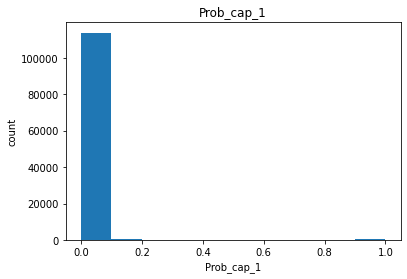

In [39]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(diff_df["Prob_cap_1"])

# set x/y labels and plot title
plt.pyplot.xlabel("Prob_cap_1")
plt.pyplot.ylabel("count")
plt.pyplot.title("Prob_cap_1")

In [40]:
# categorize from range P(0.5 - 1)
# split in 3 bins
bins = np.linspace(0.5, max(diff_df["Prob_cap_1"]), 4)
bins

array([0.5 , 0.67, 0.83, 1.  ])

In [41]:
# name bins
group_names = ['Low', 'Medium', 'High']

In [42]:
# apply the function "cut" to determine what each value of "df['Prob_cap_1']" belongs to. 
diff_df['Prob_cap_1-binned'] = pd.cut(diff_df['Prob_cap_1'], bins, labels=group_names, include_lowest=True )

In [43]:
# add 'Not Full' for range P(0,0,5)
diff_df['Prob_cap_1-binned'] = diff_df['Prob_cap_1-binned'].cat.add_categories('Not full')
diff_df['Prob_cap_1-binned'].fillna('Not full', inplace =True) 
#diff_df['Prob_cap_1-binned'].fillna(0, inplace = True) 


In [44]:
diff_df[['Prob_cap_1','Prob_cap_1-binned']].head()

,Prob_cap_1,Prob_cap_1-binned
0,0.00000883,Not full
1,0.00002824,Not full
2,0.00001006,Not full
3,0.00000498,Not full
4,0.00000301,Not full


In [45]:
diff_df['Prob_cap_1-binned'].value_counts()

Not full    114640
High           567
Low            193
Medium         176
Name: Prob_cap_1-binned, dtype: int64